In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")
# warnings.filterwarnings('ignore')

In [2]:
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [35]:
# Carga de datos
# ==============================================================================
folder = "C:\\Users\\Martinejo\\Documents\\UMH\\INVESTIGACION\\MARGARITA_SALAS\\Sistema_Riego\\"
parametro = 'eto'
output=parametro
inputs_sen = [
          'fecha', 'eto','viento_med','precip','temp_med','hr_med','rad_med'
          ]
inputs_sat = [
          'date', 'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]
usecols_sen = inputs_sen.copy()
usecols_sat = inputs_sat.copy()

datos_sen = pd.read_csv(folder + "agroclimatology_parcel_2" + ".csv",sep=',', usecols=usecols_sen)
datos_sat = pd.read_csv(folder + "teledeteccion_sentinel2_parcel_2" + ".csv",sep=',', usecols=usecols_sat)

datos_sen = datos_sen.drop_duplicates()
datos_sat = datos_sat.drop_duplicates()

#datos_sat["eto"] = 0
variable=[]
flag = 0

for k in range(len(datos_sat)):
    for q in range(len(datos_sen)):
        if(datos_sat.iloc[k].loc["date"] == datos_sen.iloc[q].loc["fecha"]):
            #print(datos_sen.iloc[q].loc["eto"])
            flag = 1
            variable.append(datos_sen.iloc[q].loc["eto"])
            #datos_sat.iloc[k].loc["eto"] = variable
            #print(variable)
    if (flag == 0):
        print(f"La fecha {datos_sat.iloc[k].loc['date']} no la tienen los sensores")
    flag = 0        
            
datos_sat["eto"] = variable

print(datos_sat)

           date  ndvi_mean  ndwi_mean  ndmi_mean  gndvi_mean  evi_mean  \
0    2022-01-01   0.295201  -0.284937   0.140327    0.284937  0.298695   
1    2022-01-05   0.016900   0.016075   0.238323   -0.016075 -0.153869   
2    2022-01-06   0.016900   0.016075   0.238323   -0.016075 -0.153869   
3    2022-01-10   0.527882  -0.577680   0.098231    0.577680  0.333104   
4    2022-01-11   0.527882  -0.577680   0.098231    0.577680  0.333104   
..          ...        ...        ...        ...         ...       ...   
222  2023-08-09   0.308893  -0.408793  -0.004755    0.408793  0.237124   
223  2023-08-14   0.315734  -0.403099  -0.010461    0.403099  0.256180   
224  2023-08-18   0.326575  -0.423031  -0.020941    0.423031  0.251530   
225  2023-08-19   0.326575  -0.423031  -0.020941    0.423031  0.251530   
226  2023-08-23   0.331303  -0.428588  -0.019626    0.428588  0.246383   

     evi2_mean  savi_mean   eto  
0     0.229052   0.222083  0.63  
1     0.025313   0.019187  2.60  
2     0.0

In [38]:
print(len(variable))

227


In [39]:
datos = datos_sat.copy()

In [40]:
datos["eto"].isna().sum()

0

In [32]:
while datos["eto"].isna().sum() > 0:
    datos = datos.fillna(value=datos.shift(1))
    datos["eto"].isna().sum()

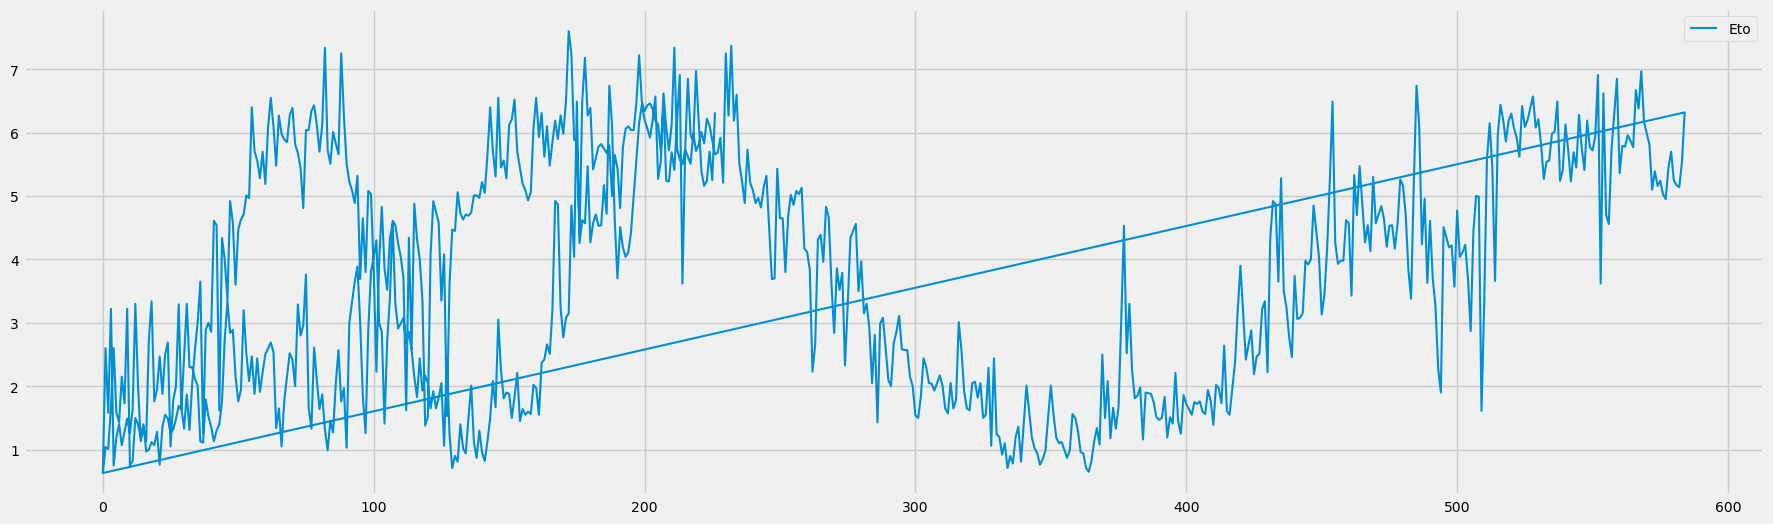

In [33]:
fig, ax = plt.subplots(figsize=(20, 6))
datos['eto'].plot(ax=ax, label='Eto')
#datos['ambiente'].plot(ax=ax, label='Ambiente')
#datos['nivel'].plot(ax=ax, label='Nivel')
ax.legend();

#COMENTAR ESTA LISTA PARA HACER EL ANÁLISIS CON LA PROPIA SERIE, Y NO CON LAS DIFERENCIAS
#datos = datos.diff().dropna()

## MODELADO

In [12]:
datos = datos.drop(columns=["date"])

In [13]:
def rmsle_cv(model,x,y):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(x.values)
    rmse= cross_val_score(model, x.values, y, scoring=None, cv = kf)
    return(rmse)

[-4.5212686  -3.72463408 -0.2127996  -0.76992911 -2.62767281]


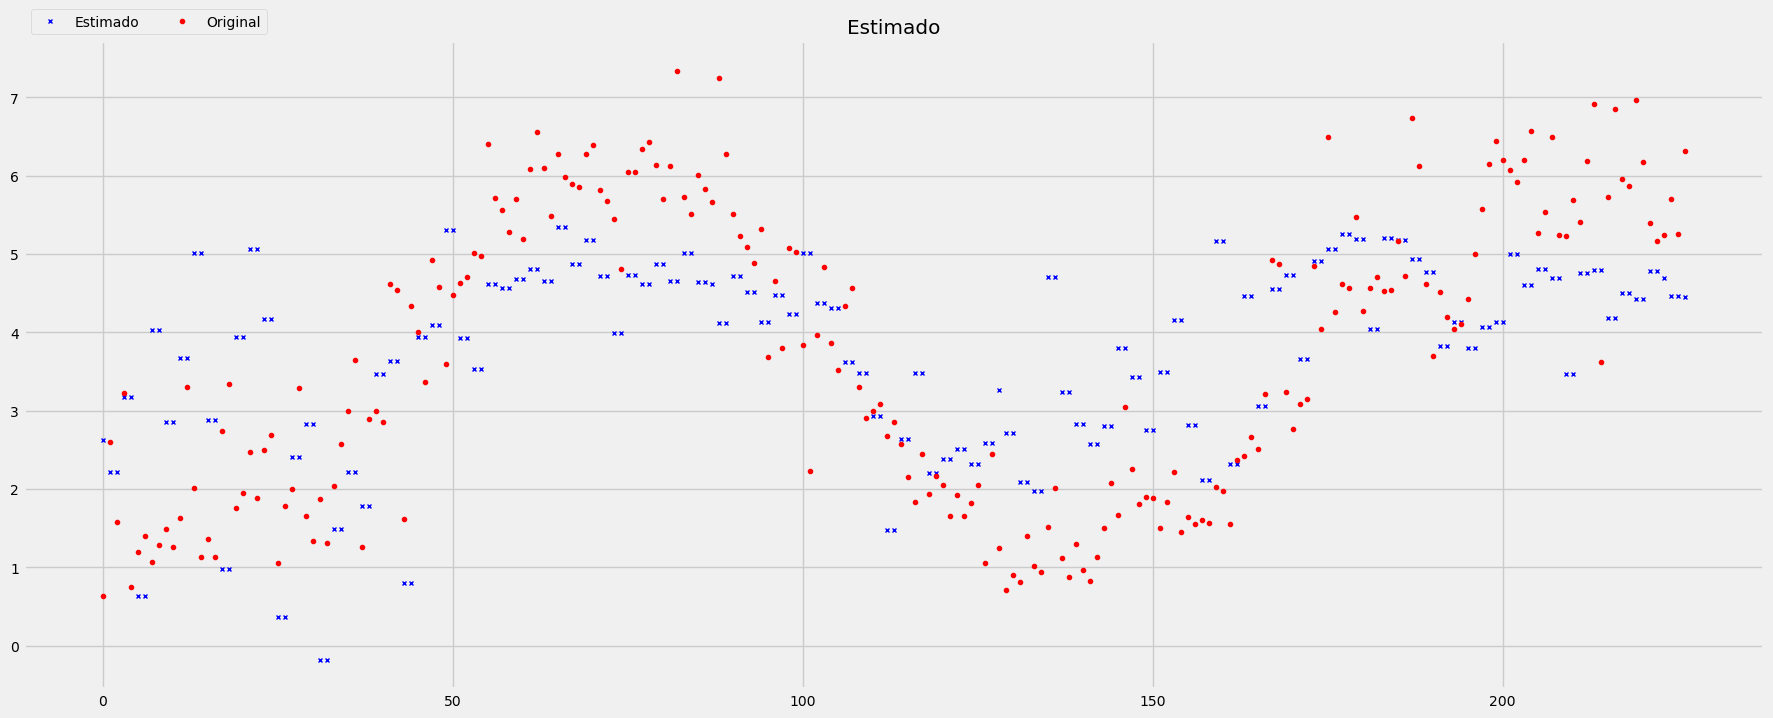

MAE = 1.038949


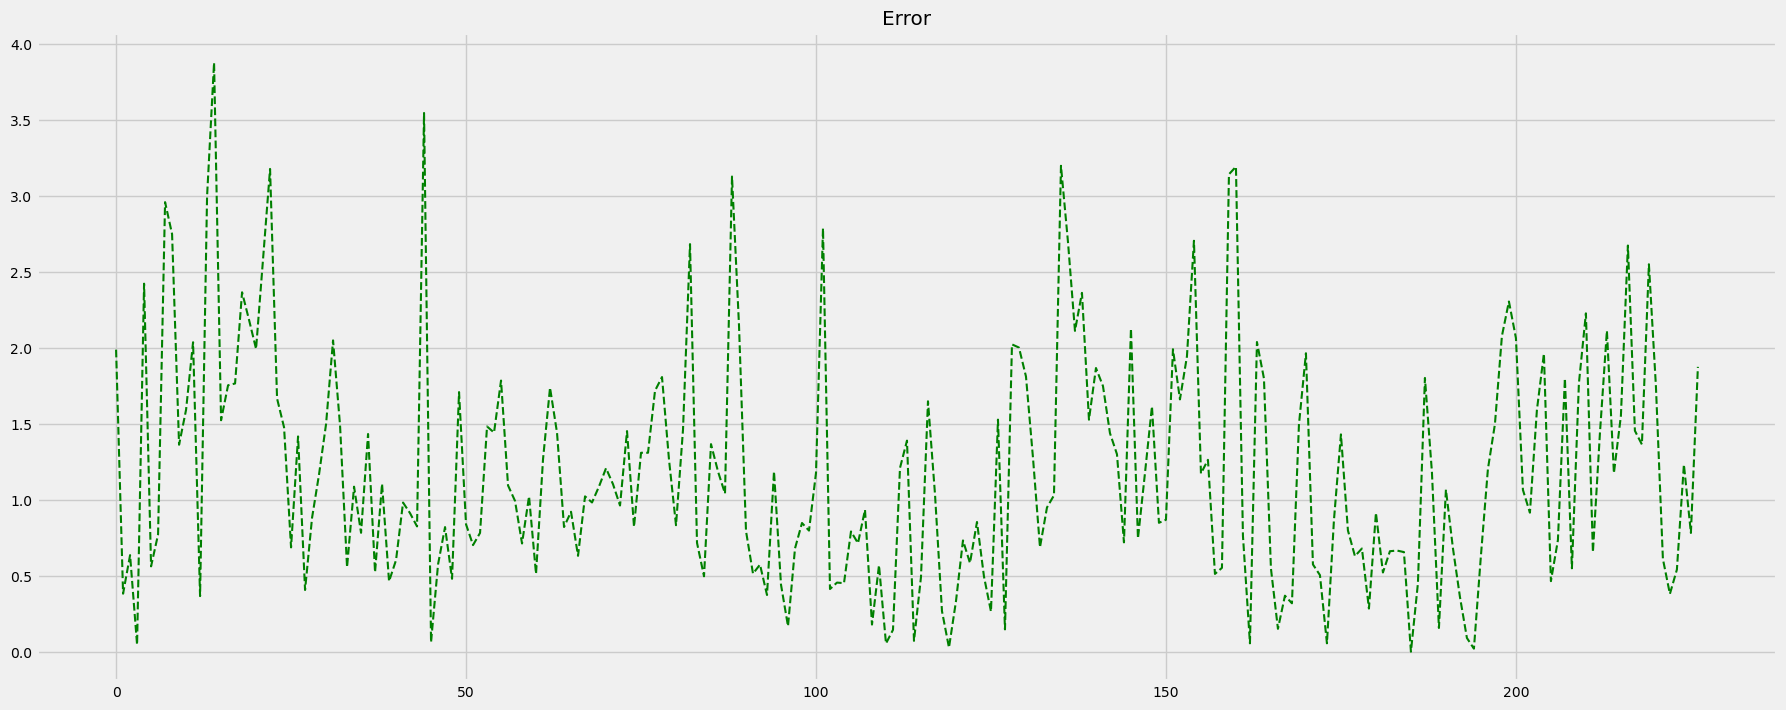

Lasso metrics: MAE = 1.1926 R2 = (0.4181)

[  -7.69443324   -5.89422374   -1.48711069    5.89422374   -1.49018705
  108.5294897  -111.32989512]


In [14]:
y_train = datos["eto"].loc[:].values
datos_train = datos.drop(columns=['eto'])

lm = linear_model.LinearRegression()
model = lm.fit(datos_train,y_train)

res_lineal = rmsle_cv(lm,datos_train,y_train)
print(res_lineal)

plt.figure(figsize=(20,8))

#plt.title('Y_predict')
l = plt.plot(lm.predict(datos_train), 'o', color='blue', label="Estimado", marker='x')
plt.setp(l, markersize=3)

plt.title('Estimado')
q = plt.plot(y_train, 'o', color='red', label="Original")
plt.setp(q, markersize=3)
category_names = ['Estimado', 'Original']
legend = plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
plt.show()

MAE_lineal = median_absolute_error(y_train, lm.predict(datos_train))
print("MAE = %f" % MAE_lineal)

errores_Lineal = abs(y_train-lm.predict(datos_train))

plt.figure(figsize=(20,8))
plt.title('Error')
plt.plot(errores_Lineal, 'r--', color='green')
plt.show()

print("Lasso metrics: MAE = {:.4f} R2 = ({:.4f})\n".format(np.mean(errores_Lineal), r2_score(y_train, lm.predict(datos_train))))

print(lm.coef_)

##EL MODELO ES MUY BUENO POR T-1, SI QUITAMOS ESTA VARIABLE EMPEORA A 0.3 APROX

In [15]:
import statsmodels.api as sm

#datos_train = datos_train.drop(columns=["evi_mean"])
#datos_train = datos_train.drop(columns=["ndmi_mean"])

data_train = sm.add_constant(datos_train)
est = sm.OLS(y_train, data_train)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     26.34
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           1.52e-23
Time:                        09:25:45   Log-Likelihood:                -401.89
No. Observations:                 227   AIC:                             817.8
Df Residuals:                     220   BIC:                             841.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0503      0.418      4.905      0.0

In [16]:
def ML_algorithms(algo):
    if algo == 'KNN':
      model = KNeighborsRegressor(9, weights='distance') # RDregresor
      return model

    if algo=="MLP":
      #(64, 32)	0.01	200.0
      model = MLPRegressor(hidden_layer_sizes=(32,32), learning_rate_init=0.01, max_iter=400, random_state=1)
      return model

    if algo=='DT':
      model = DecisionTreeRegressor(max_depth=16, min_samples_split=2,random_state=0)
      return model

    if algo=="RFR":
      #antes 16 y 4
      model =  RandomForestRegressor(random_state=0, n_estimators=8, min_samples_split=16)
      return model
  
    if algo=="LR":
        #antes 16 y 4
        model =  linear_model.LinearRegression()
        return model

In [19]:
algoritmos = ['KNN', 'MLP', 'DT', 'RFR','LR']
cv_scores = pd.DataFrame()
dfe=datos.copy()


inputs_sen = [
          'viento_med','precip','temp_med','hr_med','rad_med'
          ]

inputs_sat = [
          'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]

for algo in algoritmos:

    print("Algoritmo", algo)
    dfwork = dfe.copy()

    x = dfwork[inputs_sat].values
    y = dfwork[output].values
    
    lm = ML_algorithms(algo)
      #model = lm.fit(x,y)
    kf = KFold(5, shuffle=True, random_state=42)
    icv=0
    acc_score = []
    for train, test in kf.split(x):
      X_train, X_test, y_train, y_test = x[train], x[test], y[train], y[test]
      model = lm.fit(X_train,y_train)
      ypred = model.predict(X_test)

      r2 = r2_score(y_test, ypred)
      mae = mean_absolute_error(y_test, ypred)
      mse = mean_squared_error(y_test, ypred)
      icv = icv + 1

      result = {"Algoritmh": algo, "cv":icv, "r2" : r2, 'MAE':mae, "MSE": mse}
      cv_scores = cv_scores.append(result, ignore_index=True)

r = cv_scores.groupby(['Algoritmh']).mean()
print(r)

Algoritmo KNN
Algoritmo MLP
Algoritmo DT
Algoritmo RFR
Algoritmo LR
            cv        r2       MAE       MSE
Algoritmh                                   
DT         3.0  0.632509  0.747290  1.223021
KNN        3.0  0.657570  0.774369  1.161234
LR         3.0  0.375890  1.217005  2.103017
MLP        3.0  0.342121  1.176359  2.179568
RFR        3.0  0.622174  0.855077  1.266836


In [20]:
entreno = 10

datos_entreno = datos.iloc[:-entreno] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA

X_train = datos[inputs_sat].iloc[:-entreno]
y_train = datos[output].iloc[:-entreno]
X_test = datos[inputs_sat].iloc[-entreno:]
y_test = datos[output].iloc[-entreno:]

In [21]:
X_train.tail()

,ndvi_mean,ndwi_mean,ndmi_mean,gndvi_mean,evi_mean,evi2_mean,savi_mean
212,0.273507,-0.345741,0.059834,0.345741,0.244559,0.241354,0.224636
213,0.305773,-0.401943,-0.008996,0.401943,0.241245,0.254114,0.241375
214,0.305773,-0.401943,-0.008996,0.401943,0.241245,0.254114,0.241375
215,0.086419,-0.115714,0.005265,0.115714,0.169620,0.104714,0.086922
216,0.086419,-0.115714,0.005265,0.115714,0.169620,0.104714,0.086922


In [22]:
y_train.tail()

212    6.19
213    6.91
214    3.62
215    5.73
216    6.85
Name: eto, dtype: float64

In [23]:
X_train.describe()

,ndvi_mean,ndwi_mean,ndmi_mean,gndvi_mean,evi_mean,evi2_mean,savi_mean
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,0.296881,-0.355669,0.080496,0.355669,0.247957,0.226459,0.218558
std,0.151955,0.182566,0.143557,0.182566,0.199230,0.105584,0.104738
min,-0.022959,-0.642189,-0.077184,-0.059669,-1.531199,-0.040045,-0.028241
25%,0.169343,-0.474486,-0.008908,0.217689,0.234537,0.151596,0.146053
50%,0.335233,-0.432799,0.031251,0.432799,0.258660,0.262640,0.252290
75%,0.401484,-0.217689,0.117487,0.474486,0.304868,0.294760,0.282831
max,0.600971,0.059669,0.765513,0.642189,0.726706,0.407433,0.395798


In [24]:
y_train.describe()

count    217.000000
mean       3.657235
std        1.852037
min        0.630000
25%        1.900000
50%        3.620000
75%        5.280000
max        7.340000
Name: eto, dtype: float64

In [25]:
#model_LR =  linear_model.LinearRegression().fit(X_train,y_train)
model_LR = KNeighborsRegressor(10,weights='distance').fit(X_train,y_train)

ypred = model_LR.predict(X_test)

predicciones = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO
predicciones_fecha = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

predicciones["pred"] = ypred

r2 = r2_score(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
mse = mean_squared_error(y_test, ypred)

predicciones_fecha = X_test.copy()
predicciones_fecha["eto"] = predicciones["pred"].values

print(predicciones_fecha)

     ndvi_mean  ndwi_mean  ndmi_mean  gndvi_mean  evi_mean  evi2_mean  \
217   0.334857  -0.428700  -0.019777    0.428700  0.255080   0.265308   
218   0.334857  -0.428700  -0.019777    0.428700  0.255080   0.265308   
219   0.320527  -0.413164  -0.020899    0.413164  0.244428   0.253449   
220   0.320527  -0.413164  -0.020899    0.413164  0.244428   0.253449   
221   0.308893  -0.408793  -0.004755    0.408793  0.237124   0.254251   
222   0.308893  -0.408793  -0.004755    0.408793  0.237124   0.254251   
223   0.315734  -0.403099  -0.010461    0.403099  0.256180   0.261029   
224   0.326575  -0.423031  -0.020941    0.423031  0.251530   0.257438   
225   0.326575  -0.423031  -0.020941    0.423031  0.251530   0.257438   
226   0.331303  -0.428588  -0.019626    0.428588  0.246383   0.259273   

     savi_mean       eto  
217   0.255685  5.733895  
218   0.255685  5.733895  
219   0.244396  5.186980  
220   0.244396  5.186980  
221   0.242177  5.172934  
222   0.242177  5.172934  
223   0

Evaluation metric results:-
MSE: 0.5300074657348028
MAE: 0.4875548006331073
RMSE: 0.7280161163977091
MAPE: 7.721281842190885
R2: -0.7605823317581424



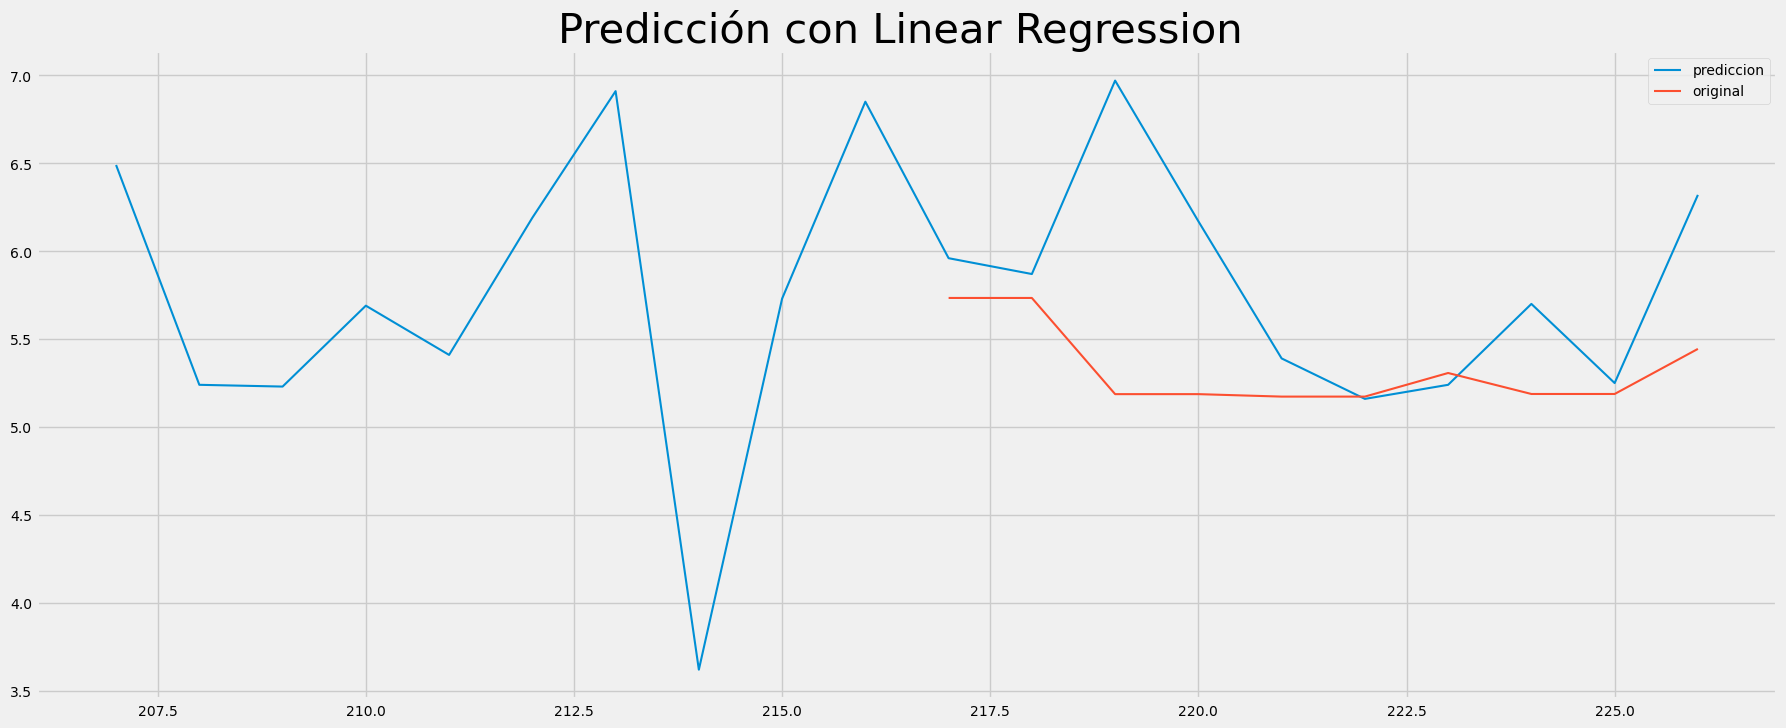

In [26]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title("Predicción con Linear Regression ", fontsize=30);
#df_train['temperatura'].plot(ax=ax, label='train')
datos["eto"].tail(10+entreno).plot(ax=ax, label='prediccion')
predicciones_fecha["eto"].plot(ax=ax, label='original')
ax.legend();

evaluacion_metrica(y_true = y_test,y_pred = predicciones_fecha["eto"])


In [27]:
def KNN(nestimators):
      model = KNeighborsRegressor(nestimators,weights='distance') # RDregresor
      return model

def MLP(layer=(32,32), lr = 0.001, max_iter=400):
      model =  MLPRegressor(hidden_layer_sizes=layer, learning_rate_init=lr, max_iter=max_iter, random_state=1)
      return model

def DT(depth, mss):
  model = DecisionTreeRegressor(max_depth=depth, min_samples_split=mss,random_state=0)
  return model

def RFR(nestimators=8, mss=16):
  model =  RandomForestRegressor(random_state=0, n_estimators=nestimators, min_samples_split=mss)
  return model

In [28]:
dfe=datos.copy()

layers = [(32,32) , (64,64), (64,32), (32,64), (32,16)] #MLP
lrs = [0.1, 0.01, 0.001, 0.0001] #MLP
max_iters = [10, 50, 100, 200, 400, 800] #MLP

max_depth = [4,8,10,16,30,60,120] #DT
mss = [2,4,8,16,32,64] #DT , RFR
nstimator=[1,2,3,4,5,6,7,8,9,10] # RFR, KNN


model_loop = layers
model_loop2 = lrs

best_model = None
best_model_I = 0
best_score = 0
cv_scores_DT = pd.DataFrame()
cv_scores_KNN = pd.DataFrame()
cv_scores_best = pd.DataFrame()

#================================ DT ==================================

for ns in max_depth:

    for ms in mss:

        dfwork = dfe.copy()

        x = dfwork[inputs_sat].values
        y = dfwork[output].values

        model = DT(ns, ms)
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

        if (scores.mean() > best_score):
            best_score = scores.mean()
            best_model = model
            result = {"Parametro1": ns, "Parametro2": ms, 'score':scores.mean()}
            
cv_scores_DT = cv_scores_DT.append(result, ignore_index=True)
print("=============== DT =================")
print(cv_scores_DT.sort_values('score', ascending=False))

param_DT=[cv_scores_DT["Parametro1"].median(), cv_scores_DT["Parametro2"].median()]


#================================ KNN ==================================

best_score=0

for nstim in nstimator:

    dfwork = dfe.copy()

    x = dfwork[inputs_sat].values
    y = dfwork[output].values

    model = KNN(nstim)
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

    if (scores.mean() > best_score):
        best_score = scores.mean()
        best_model = model
        result = {"Parametro1": nstim, 'score':scores.mean()}

cv_scores_KNN = cv_scores_KNN.append(result, ignore_index=True)

print("=============== KNN =================")
print(cv_scores_KNN.sort_values('score', ascending=False))

param_KNN=[cv_scores_KNN["Parametro1"].median()]

=============== DT =================
   Parametro1  Parametro2     score
0        16.0         8.0  0.555611
=============== KNN =================
   Parametro1     score
0        10.0  0.636348
